# 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
from sklearn.metrics import mean_absolute_error
import pickle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,StandardScaler,PowerTransformer,MinMaxScaler
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.diagnostic import linear_rainbow,linear_harvey_collier
from itertools import combinations
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold,GridSearchCV
import tensorflow as tf
from scipy.stats import spearmanr,pearsonr
from xgboost import XGBRegressor
warnings.filterwarnings(action='ignore')

# 데이터로드

In [2]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
forward_df = fm_data_df[fm_data_df['포지션']=='공격수']
forward_df = forward_df.reset_index(drop=True)

# 공격수 EDA

In [3]:
# 데이터 분석에 필요한 변수만 추출

num_col = [forward_df.columns[i] for i,x in enumerate(forward_df.dtypes) if x == 'int64' or x == 'float64']
features = list(set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90']))
target = ['평균획득승점/경기']

## 종속변수

### 종속변수가 정규분포를 만족하지 않음

In [4]:
from scipy.stats import kstest,shapiro

kstest(forward_df.loc[:,target],'norm')

KstestResult(statistic=0.9980737908678121, pvalue=0.0)

### 종속변수 시각화

<AxesSubplot:xlabel='평균획득승점/경기', ylabel='Density'>

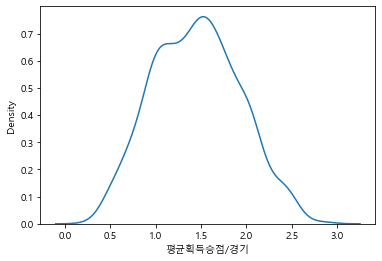

In [5]:
sns.kdeplot(x='평균획득승점/경기',data=forward_df)

## 이상치 확인

### 이상치 시각화

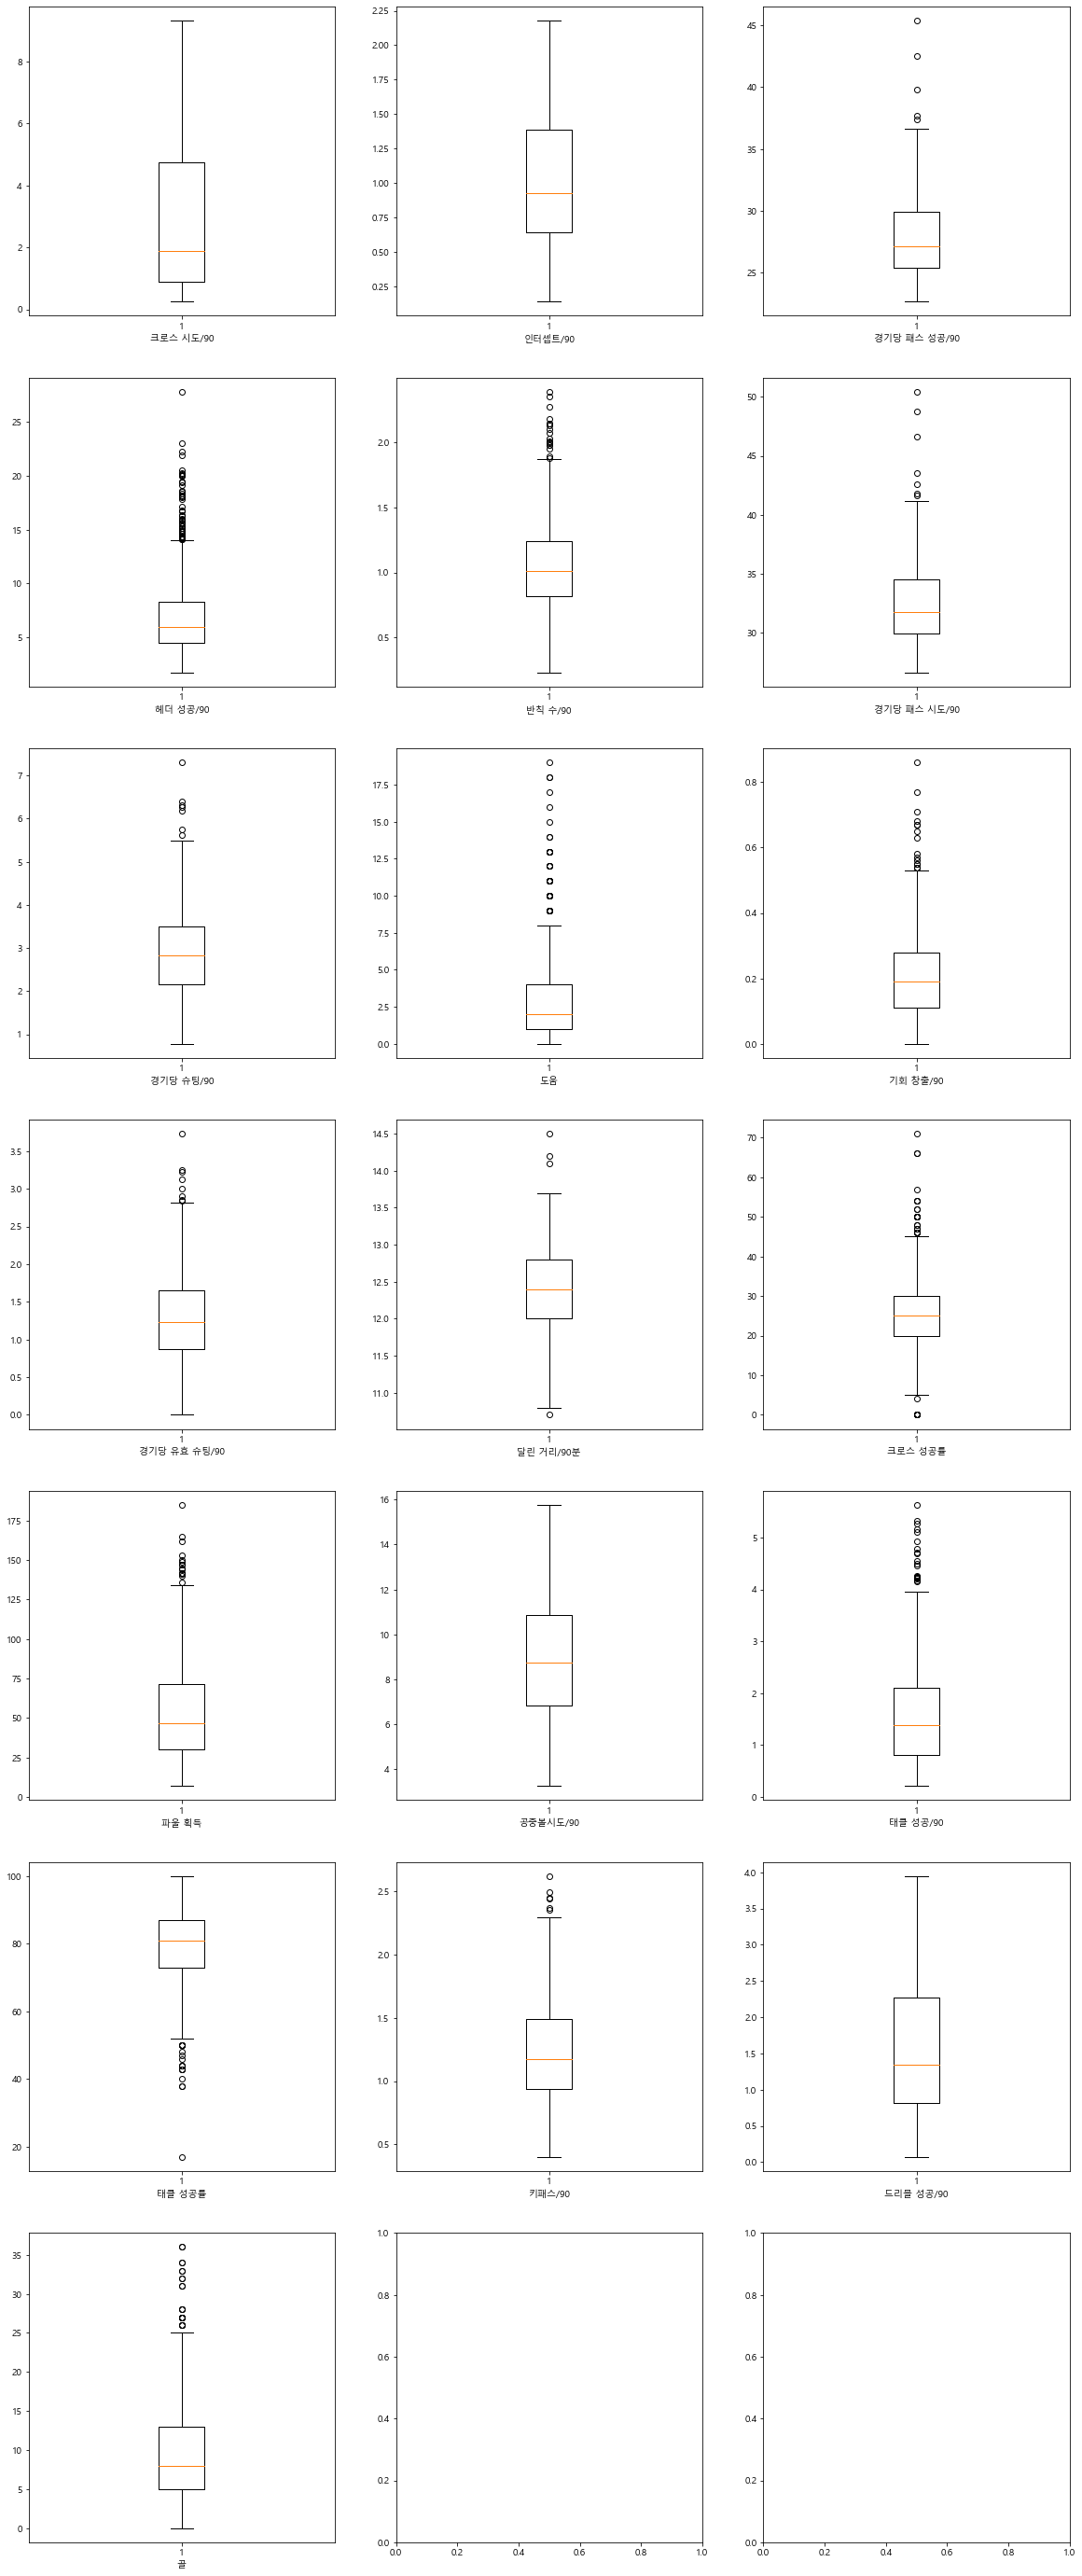

In [6]:
# 모든 변수의 Box plot 시각화

fig , axes = plt.subplots(7,3,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_xlabel(feature)
    ax.boxplot(forward_df.loc[:,feature])
    
plt.show()

### 이상치의 비율 확인

In [7]:
# 데이터 당 이상치의 비율을 구하기
# 데이터는 990개인데 이상치가 그다지 많지 않다.
# 그래서 이상치의 비율이 5%가 넘는 변수만 tranformer를 적용한다.

out_ratio = defaultdict(float)

order_feature = ['골','도움']

for feature in set(features)-set(order_feature):
    
    data = forward_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    out_ratio[feature] = (len(data[data>high_bound]) + len(data[data>=high_bound])) / len(data)
    
sorted_outlier_ratio = sorted(out_ratio.items(),key=lambda x : x[1],reverse=True)

for k,v in sorted_outlier_ratio:
    print(f'{k}의 데이터 중 {np.round(v*100,3)}%가 이상치 입니다.')
    
outlier_features = [k for k,v in out_ratio.items() if v > 0.05]
nonoutlier_features = list((set(features) - set(outlier_features)) -set(order_feature))

헤더 성공/90의 데이터 중 16.364%가 이상치 입니다.
태클 성공/90의 데이터 중 8.283%가 이상치 입니다.
반칙 수/90의 데이터 중 6.465%가 이상치 입니다.
기회 창출/90의 데이터 중 6.061%가 이상치 입니다.
크로스 성공률의 데이터 중 5.859%가 이상치 입니다.
파울 획득의 데이터 중 5.657%가 이상치 입니다.
키패스/90의 데이터 중 3.838%가 이상치 입니다.
경기당 유효 슈팅/90의 데이터 중 3.434%가 이상치 입니다.
경기당 패스 시도/90의 데이터 중 3.434%가 이상치 입니다.
경기당 슈팅/90의 데이터 중 2.222%가 이상치 입니다.
경기당 패스 성공/90의 데이터 중 1.414%가 이상치 입니다.
크로스 시도/90의 데이터 중 1.212%가 이상치 입니다.
달린 거리/90분의 데이터 중 0.606%가 이상치 입니다.
드리블 성공/90의 데이터 중 0.202%가 이상치 입니다.
공중볼시도/90의 데이터 중 0.0%가 이상치 입니다.
인터셉트/90의 데이터 중 0.0%가 이상치 입니다.
태클 성공률의 데이터 중 0.0%가 이상치 입니다.


## 선형성 검정

### 선형성 시각화

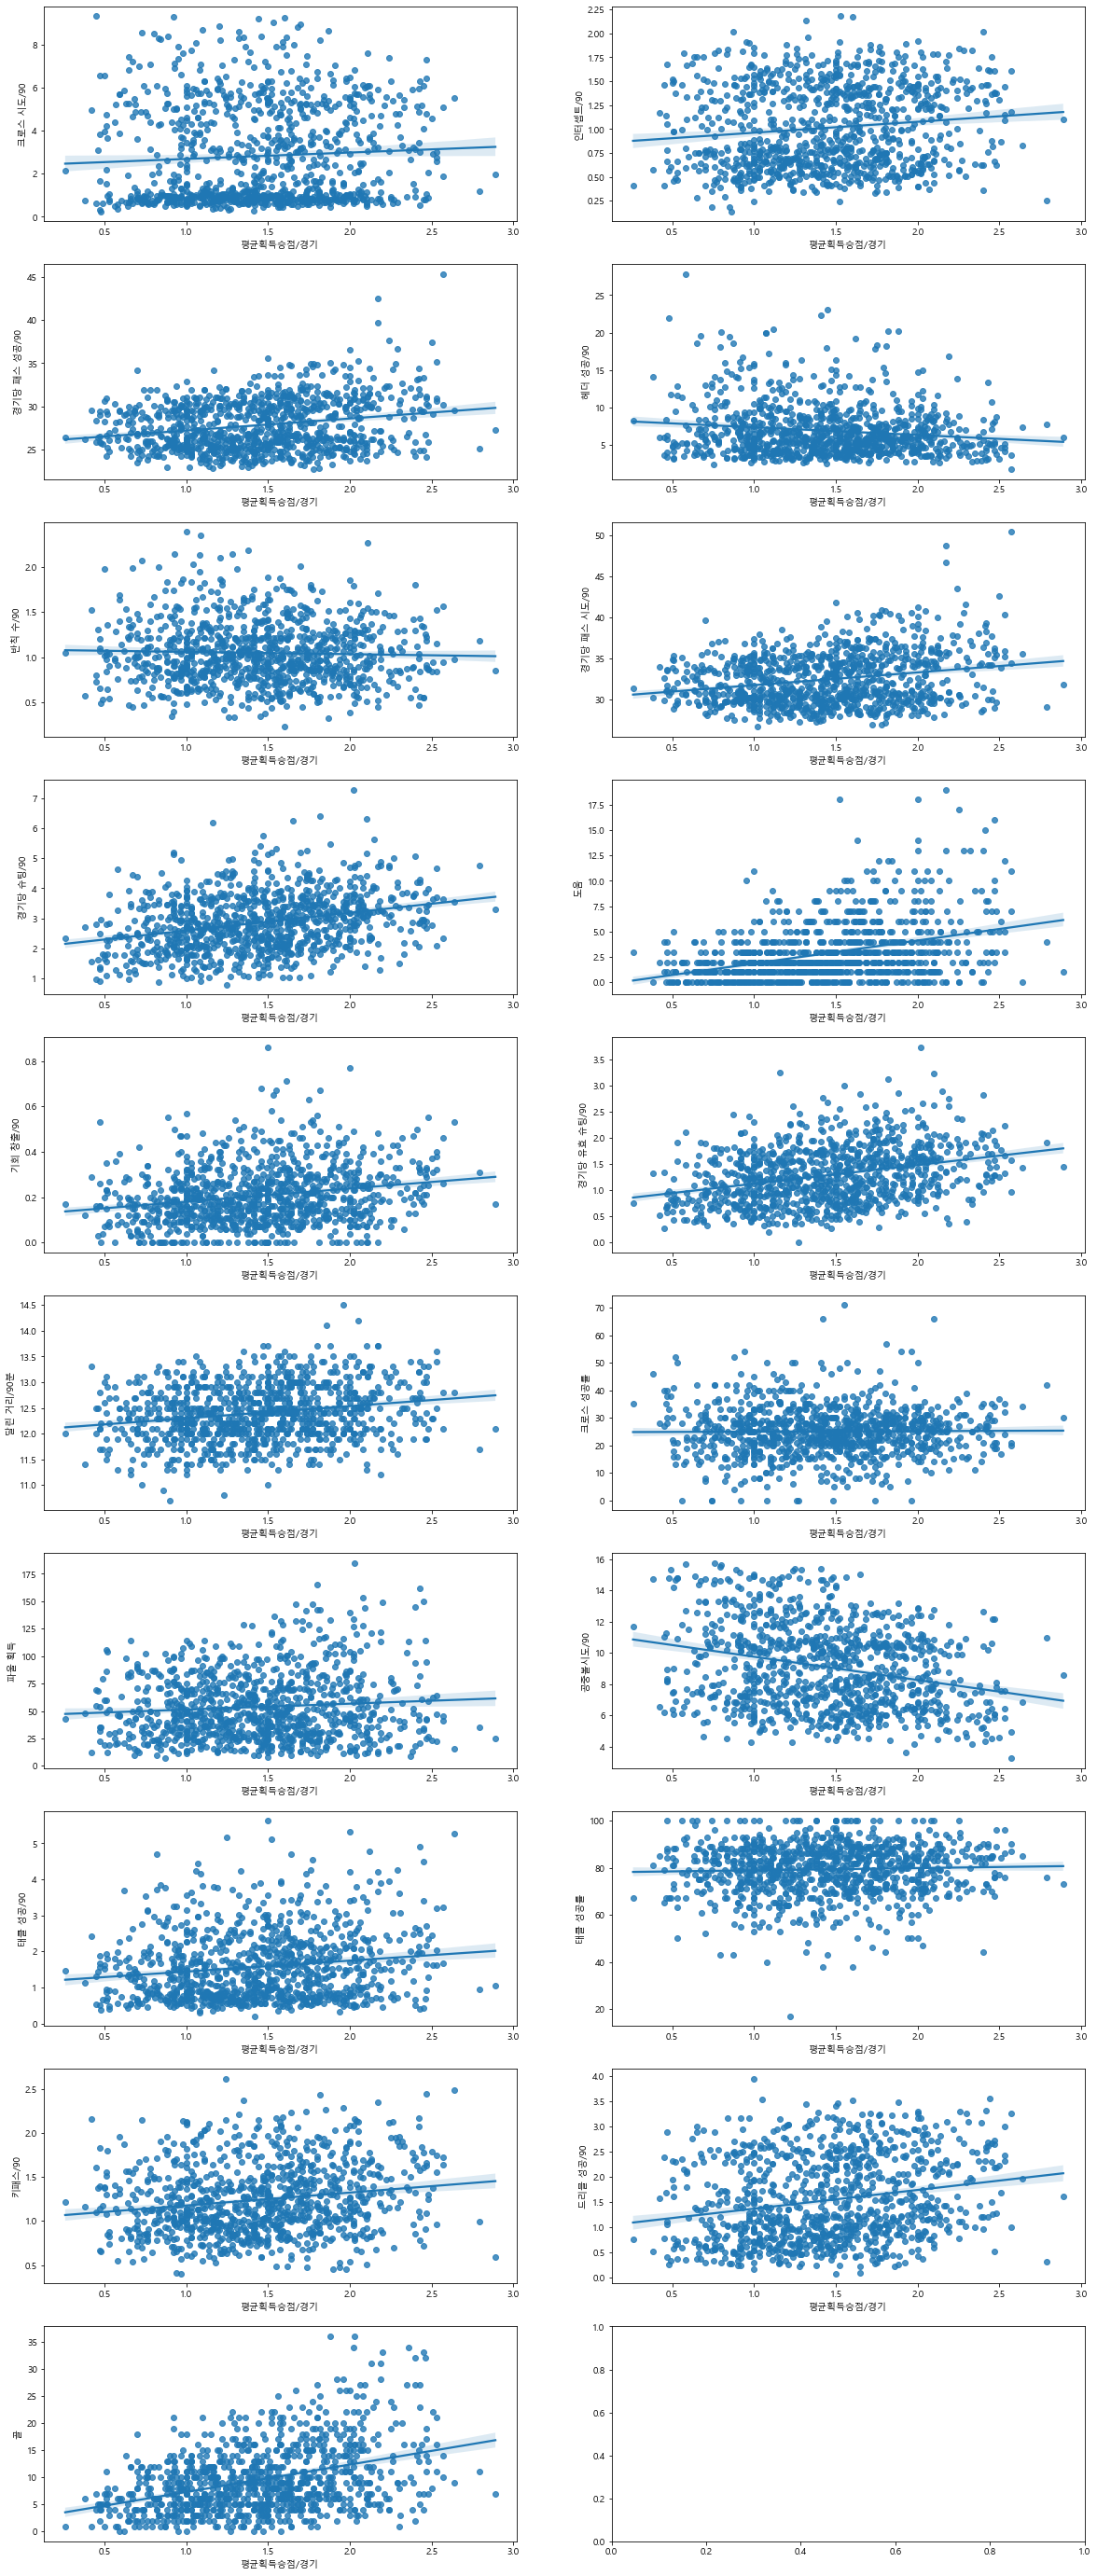

In [8]:
# scatter plot을 이용해서 선형성 검정
# 대부분의 피쳐가 선형성이 없어 보인다.

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    sns.regplot(forward_df.loc[:,target],forward_df.loc[:,feature],ax=ax)
    
plt.show()

### 통계치로 선형성 확인

In [9]:
# target value와의 correlation을 가지고 선형성 확인

corr = [np.corrcoef(x ,y=forward_df.loc[:,target].T.values)[0][1] for x in forward_df.loc[:,features].T.values]

corr_dict = {}

for i,v in enumerate(corr):
    corr_dict[features[i]] = v

sorted(corr_dict.items(),key = lambda x : x[1],reverse=True)

[('골', 0.3899925372047754),
 ('도움', 0.3727750769369584),
 ('경기당 유효 슈팅/90', 0.3149008868945989),
 ('경기당 슈팅/90', 0.2943168941980925),
 ('경기당 패스 시도/90', 0.23483275556330324),
 ('경기당 패스 성공/90', 0.22567263258441708),
 ('기회 창출/90', 0.21355111596989557),
 ('드리블 성공/90', 0.21124806922396683),
 ('달린 거리/90분', 0.20850002371280105),
 ('키패스/90', 0.17434639122051926),
 ('태클 성공/90', 0.1533561266754542),
 ('인터셉트/90', 0.12639405293658518),
 ('파울 획득', 0.08483611536148467),
 ('크로스 시도/90', 0.06285626018412958),
 ('태클 성공률', 0.04108875139565955),
 ('크로스 성공률', 0.01034149433563985),
 ('반칙 수/90', -0.03516430428187815),
 ('헤더 성공/90', -0.14336317747602786),
 ('공중볼시도/90', -0.2635664616800462)]

## 다중 공선성 확인

### VIF 확인

In [10]:
this_vif = pd.DataFrame()
this_vif["VIF Factor"] = [vif(forward_df.loc[:,features].values,i) for i in range(forward_df.loc[:,features].values.shape[1])]
this_vif["feautures"] = forward_df.loc[:,features].columns
this_vif = this_vif.sort_values("VIF Factor").reset_index(drop=True)
this_vif

,VIF Factor,feautures
0,3.788092,도움
1,4.842201,기회 창출/90
2,9.795654,크로스 성공률
3,9.811395,크로스 시도/90
4,12.446589,반칙 수/90
5,12.987407,골
6,13.549914,태클 성공/90
7,15.434996,파울 획득
8,18.562202,헤더 성공/90
9,21.472031,드리블 성공/90


### 상관계수 확인

In [11]:
feature_comb = list(combinations(features,2))
corr_dict_pair = {}
for a,b in feature_comb:
    spearmann = spearmanr(forward_df[[a,b]])
    corr_dict_pair[f'{a}/{b}'] = (spearmann[0],spearmann[1])

sorted(corr_dict_pair.items(),key=lambda x : np.abs(x[1][0]),reverse=True)

[('경기당 패스 성공/90/경기당 패스 시도/90', (0.9757693697539498, 0.0)),
 ('경기당 슈팅/90/경기당 유효 슈팅/90', (0.9197568720416062, 0.0)),
 ('인터셉트/90/드리블 성공/90', (0.8391300965855942, 1.575944931151397e-263)),
 ('크로스 시도/90/드리블 성공/90', (0.7708906944851575, 9.660405634579921e-196)),
 ('크로스 시도/90/태클 성공/90', (0.770467867550075, 2.135887710775192e-195)),
 ('크로스 시도/90/경기당 패스 성공/90', (0.7637011554294952, 5.56153286098223e-190)),
 ('공중볼시도/90/드리블 성공/90', (-0.7587068459216181, 4.234980442630381e-186)),
 ('크로스 시도/90/경기당 패스 시도/90', (0.7550404243075445, 2.6099647502200166e-183)),
 ('크로스 시도/90/인터셉트/90', (0.7548551017529648, 3.6002599575130127e-183)),
 ('파울 획득/골', (0.7515666521498854, 1.0342071716269627e-180)),
 ('인터셉트/90/경기당 패스 성공/90', (0.7416773956981074, 1.5141215562247686e-173)),
 ('인터셉트/90/경기당 패스 시도/90', (0.7294548793307659, 3.932290340169915e-165)),
 ('경기당 패스 성공/90/드리블 성공/90', (0.7153217222613918, 5.851830185097394e-156)),
 ('크로스 시도/90/키패스/90', (0.7042803195246555, 3.567488661297425e-149)),
 ('경기당 패스 성공/90/달린 거리/90분', 

### 삭제할 변수, 통합해야 할 변수 고르기

1. 삭제할 변수: 달린 거리/90분,태클 성공률,인터셉트/90,태클 성공/90, 반칙 수/90


2. 통합해야 할 변수: (경기당 패스 시도/90,경기당 패스 성공/90) , (경기당 유효 슈팅/90,경기당 슈팅/90), (공중볼시도/90,헤더 성공/90)


3. 다중 공선성 해결 후: 다시 고려해 볼 변수 : 키패스/90, 드리블 성공/90 ,파울 획득, 골

### 피쳐 엔지니어링 

목표: 피쳐 엔지니어링을 통해 선형성 만들기

(경기당 패스 시도/90,경기당 패스 성공/90) , (경기당 유효 슈팅/90,경기당 슈팅/90), (공중볼시도/90,헤더 성공/90)

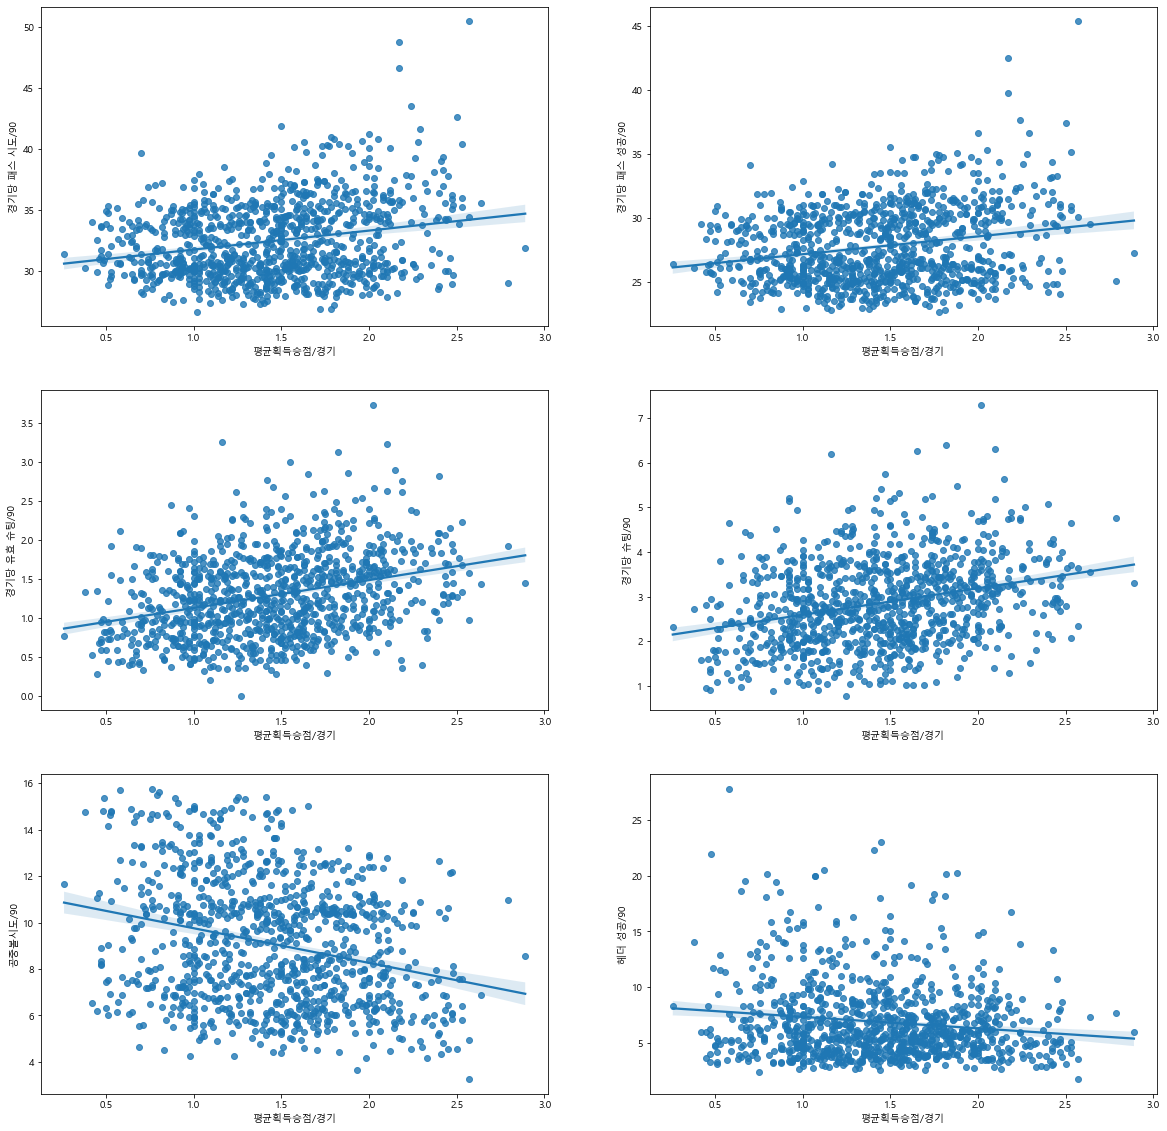

In [12]:
fig , axes = plt.subplots(3,2,figsize=(20,20))

for i, (ax,feature) in enumerate(zip(axes.ravel(),['경기당 패스 시도/90','경기당 패스 성공/90','경기당 유효 슈팅/90','경기당 슈팅/90','공중볼시도/90','헤더 성공/90'])) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    sns.regplot(forward_df.loc[:,target],forward_df.loc[:,feature],ax=ax)
    
plt.show()

In [13]:
corr_dict

{'크로스 시도/90': 0.06285626018412958,
 '인터셉트/90': 0.12639405293658518,
 '경기당 패스 성공/90': 0.22567263258441708,
 '헤더 성공/90': -0.14336317747602786,
 '반칙 수/90': -0.03516430428187815,
 '경기당 패스 시도/90': 0.23483275556330324,
 '경기당 슈팅/90': 0.2943168941980925,
 '도움': 0.3727750769369584,
 '기회 창출/90': 0.21355111596989557,
 '경기당 유효 슈팅/90': 0.3149008868945989,
 '달린 거리/90분': 0.20850002371280105,
 '크로스 성공률': 0.01034149433563985,
 '파울 획득': 0.08483611536148467,
 '공중볼시도/90': -0.2635664616800462,
 '태클 성공/90': 0.1533561266754542,
 '태클 성공률': 0.04108875139565955,
 '키패스/90': 0.17434639122051926,
 '드리블 성공/90': 0.21124806922396683,
 '골': 0.3899925372047754}

#### 슈팅 피쳐 엔지니어링

In [14]:
forward_df[['경기당 유효 슈팅/90']].describe()

,경기당 유효 슈팅/90
count,990.000000
mean,1.284970
std,0.540925
min,0.000000
25%,0.870000
50%,1.235000
75%,1.650000
max,3.730000


In [15]:
forward_df[['경기당 슈팅/90']].describe()

,경기당 슈팅/90
count,990.000000
mean,2.858586
std,0.966584
min,0.780000
25%,2.150000
50%,2.820000
75%,3.490000
max,7.300000


<AxesSubplot:xlabel='경기당 유효 슈팅/90', ylabel='경기당 슈팅/90'>

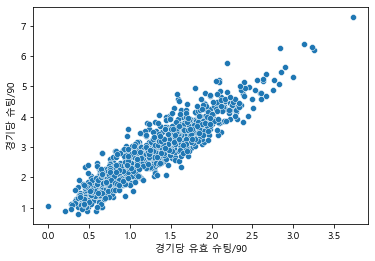

In [16]:
sns.scatterplot(x='경기당 유효 슈팅/90' , y='경기당 슈팅/90', data=forward_df)

In [17]:
forward_df['가중슛'] = ((forward_df['경기당 유효 슈팅/90']*1.3)**2 * (forward_df['경기당 슈팅/90']*0.5)**2)

#spearmanr(forward_df[['상관계수가중슛','평균획득승점/경기']])
pearsonr(forward_df['가중슛'],forward_df['평균획득승점/경기'])

(0.20588955822973531, 6.144785578349722e-11)

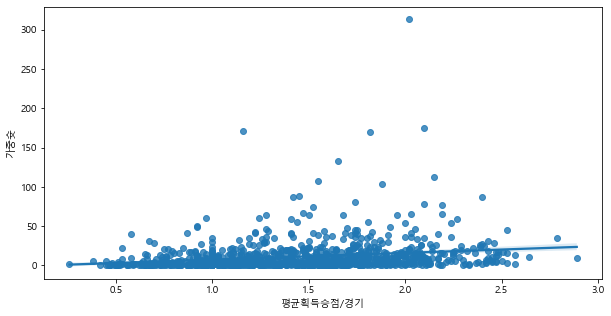

In [18]:
plt.figure(figsize=(10,5))
sns.regplot(forward_df.loc[:,target],forward_df.loc[:,'가중슛'])
plt.show()

#### 패스 피쳐 엔지니어링

In [19]:
forward_df[['경기당 패스 시도/90']].describe()

,경기당 패스 시도/90
count,990.000000
mean,32.425040
std,3.159853
min,26.620000
25%,29.970000
50%,31.760000
75%,34.520000
max,50.450000


In [20]:
forward_df[['경기당 패스 성공/90']].describe()

,경기당 패스 성공/90
count,990.000000
mean,27.803535
std,2.941837
min,22.680000
25%,25.442500
50%,27.105000
75%,29.947500
max,45.380000


<AxesSubplot:xlabel='경기당 패스 시도/90', ylabel='경기당 패스 성공/90'>

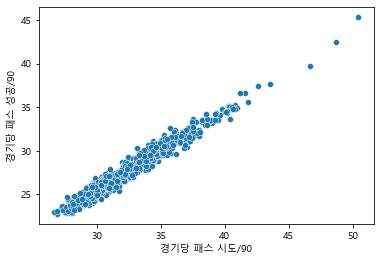

In [21]:
sns.scatterplot(x='경기당 패스 시도/90' , y='경기당 패스 성공/90', data=forward_df)

In [22]:
forward_df['가중패스'] = ((forward_df['경기당 패스 시도/90']**2) * (forward_df['경기당 패스 성공/90']**2))

#spearmanr(forward_df[['상관계수가중슛','평균획득승점/경기']])
pearsonr(forward_df['가중패스'],forward_df['평균획득승점/경기'])

(0.2546310274306386, 4.08104234435671e-16)

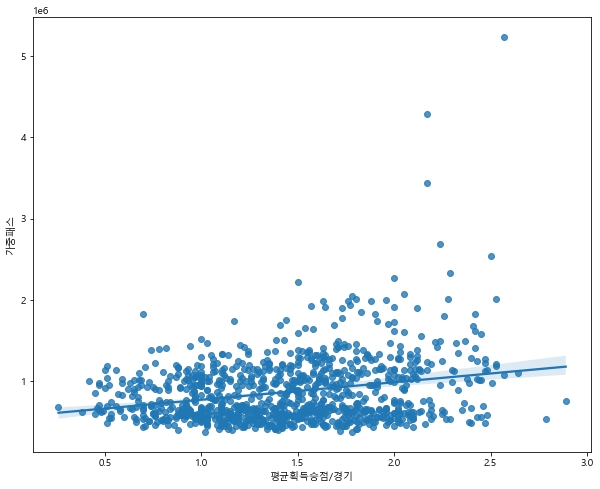

In [23]:
plt.figure(figsize=(10,8))
sns.regplot(forward_df.loc[:,target],forward_df.loc[:,'가중패스'])
plt.show()

#### 헤더 피쳐 엔지니어링

In [24]:
forward_df[['헤더 성공/90']].describe()

,헤더 성공/90
count,990.000000
mean,6.858192
std,3.441331
min,1.710000
25%,4.450000
50%,5.975000
75%,8.290000
max,27.840000


In [25]:
forward_df[['공중볼시도/90']].describe()

,공중볼시도/90
count,990.000000
mean,9.083687
std,2.701621
min,3.250000
25%,6.832500
50%,8.755000
75%,10.857500
max,15.770000


<AxesSubplot:xlabel='헤더 성공/90', ylabel='공중볼시도/90'>

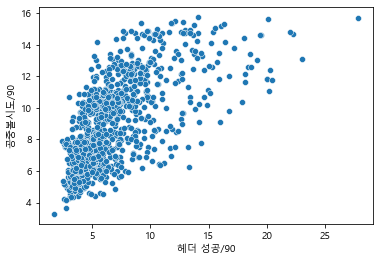

In [26]:
sns.scatterplot(x='헤더 성공/90' , y='공중볼시도/90', data=forward_df)

In [27]:
forward_df['가중헤더'] = (forward_df['헤더 성공/90']**2) * (forward_df['공중볼시도/90']**2)

#spearmanr(forward_df[['상관계수가중슛','평균획득승점/경기']])
pearsonr(forward_df['가중헤더'],forward_df['평균획득승점/경기'])

(-0.20477001115195775, 7.829788604685908e-11)

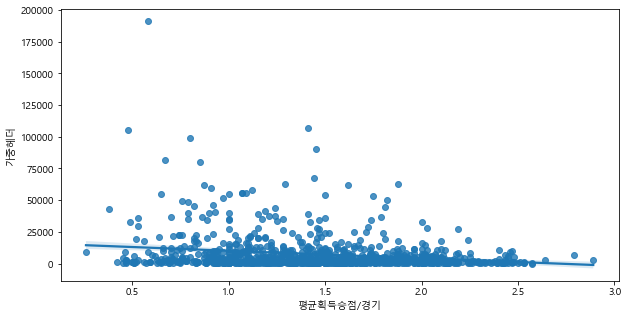

In [28]:
plt.figure(figsize=(10,5))
sns.regplot(forward_df.loc[:,target],forward_df.loc[:,'가중헤더'])
plt.show()

In [29]:
df_columns = list(set(forward_df.columns) - set(['달린 거리/90분','태클 성공률','인터셉트/90','태클 성공/90'
                     ,'반칙 수/90','헤더 성공/90','공중볼시도/90','경기당 패스 시도/90'
                     , '경기당 패스 성공/90','경기당 유효 슈팅/90','경기당 슈팅/90']))

In [30]:
forward_df = forward_df[df_columns]
forward_df.columns

Index(['경기당 팀 실점/90', '임대 기간', '경기당 팀 득점/90', '출장시간', '크로스 시도/90', '가중헤더',
       '시즌', '도움', '기회 창출/90', '평균획득승점/경기', '가중패스', '크로스 성공률', '무', '패',
       '파울 획득', '리그', '가중슛', '키패스/90', '포지션', '승', '이름', '드리블 성공/90', '골',
       '구단'],
      dtype='object')

In [31]:
features = list(set(features) - set(['달린 거리/90분','태클 성공률','인터셉트/90','태클 성공/90'
                     ,'반칙 수/90','헤더 성공/90','공중볼시도/90','경기당 패스 시도/90'
                     , '경기당 패스 성공/90','경기당 유효 슈팅/90','경기당 슈팅/90']))

features.extend(['가중슛','가중패스','가중헤더'])

features

['도움',
 '기회 창출/90',
 '키패스/90',
 '크로스 성공률',
 '파울 획득',
 '크로스 시도/90',
 '드리블 성공/90',
 '골',
 '가중슛',
 '가중패스',
 '가중헤더']

In [32]:
forward_df.head()

,경기당 팀 실점/90,임대 기간,경기당 팀 득점/90,출장시간,크로스 시도/90,가중헤더,시즌,도움,기회 창출/90,평균획득승점/경기,...,파울 획득,리그,가중슛,키패스/90,포지션,승,이름,드리블 성공/90,골,구단
0,1.81,21/7/5 - 22/6/30,1.18,992.0,0.64,81331.739044,2021-2022,0,0.09,0.67,...,27,독일 분데스리가,30.522034,0.54,공격수,5.0,Cedric Itten,0.36,6,퓌르트
1,2.09,0,1.35,2673.0,0.67,1896.950916,2021-2022,1,0.03,0.73,...,85,독일 분데스리가,1.039829,0.77,공격수,7.0,Branimir Hrgota,0.98,12,퓌르트
2,1.99,0,1.16,3249.0,0.86,10234.863056,2021-2022,2,0.19,0.66,...,114,독일 분데스리가,13.300755,0.80,공격수,6.0,Håvard Nielsen,0.47,12,퓌르트
3,1.34,0,2.10,3951.0,0.82,9536.733398,2021-2022,11,0.32,1.88,...,133,독일 분데스리가,103.433477,1.30,공격수,29.0,Erling Haaland,0.84,36,도르트문트
4,1.05,0,2.30,1797.0,1.00,1571.971834,2021-2022,4,0.10,2.00,...,43,독일 분데스리가,11.485999,1.15,공격수,22.0,Thorgan Hazard,0.75,15,도르트문트


In [33]:
this_vif = pd.DataFrame()
this_vif["VIF Factor"] = [vif(forward_df.loc[:,features].values,i) for i in range(forward_df.loc[:,features].values.shape[1])]
this_vif["features"] = forward_df.loc[:,features].columns
this_vif = this_vif.sort_values("VIF Factor").reset_index(drop=True)
this_vif

,VIF Factor,features
0,1.491168,가중헤더
1,1.730155,가중슛
2,3.250950,도움
3,4.649582,기회 창출/90
4,7.408775,크로스 성공률
5,8.226766,크로스 시도/90
6,9.468267,가중패스
7,10.467733,골
8,10.618247,파울 획득
9,11.116018,드리블 성공/90


## 변수 정규화 및 변수 선택

In [34]:
out_ratio = defaultdict(float)

order_feature = ['골','도움']

for feature in set(features)-set(order_feature):
    
    data = forward_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    out_ratio[feature] = (len(data[data>high_bound]) + len(data[data>=high_bound])) / len(data)
    
sorted_outlier_ratio = sorted(out_ratio.items(),key=lambda x : x[1],reverse=True)

for k,v in sorted_outlier_ratio:
    print(f'{k}의 데이터 중 {np.round(v*100,3)}%가 이상치 입니다.')
    
outlier_features = [k for k,v in out_ratio.items() if v > 0.05]
nonoutlier_features = list((set(features) - set(outlier_features)) -set(order_feature))

가중헤더의 데이터 중 27.071%가 이상치 입니다.
가중슛의 데이터 중 19.596%가 이상치 입니다.
가중패스의 데이터 중 7.475%가 이상치 입니다.
기회 창출/90의 데이터 중 6.061%가 이상치 입니다.
크로스 성공률의 데이터 중 5.859%가 이상치 입니다.
파울 획득의 데이터 중 5.657%가 이상치 입니다.
키패스/90의 데이터 중 3.838%가 이상치 입니다.
크로스 시도/90의 데이터 중 1.212%가 이상치 입니다.
드리블 성공/90의 데이터 중 0.202%가 이상치 입니다.


### 변수 정규화

In [35]:
norm_forward_df = forward_df.copy()

forward_qt = QuantileTransformer(n_quantiles=100,output_distribution='normal').fit(norm_forward_df.loc[:,features])
norm_forward_df.loc[:,features] = forward_qt.transform(norm_forward_df.loc[:,features])

In [36]:
outlier_features

['가중슛', '기회 창출/90', '가중헤더', '가중패스', '크로스 성공률', '파울 획득']

In [37]:
nonoutlier_features

['키패스/90', '크로스 시도/90', '드리블 성공/90']

### 상관계수와 시각화를 통한 변수 선택

In [38]:
feature_comb = list(combinations(features,2))

In [39]:
'''
fig , axes = plt.subplots(43,4,figsize=(100,860))

for i,(ax,feature) in enumerate(zip(axes.ravel(),feature_comb)):
    sns.scatterplot(x = forward_df.loc[:,feature[0]], y= forward_df.loc[:,feature[1]],ax=ax)
'''

'\nfig , axes = plt.subplots(43,4,figsize=(100,860))\n\nfor i,(ax,feature) in enumerate(zip(axes.ravel(),feature_comb)):\n    sns.scatterplot(x = forward_df.loc[:,feature[0]], y= forward_df.loc[:,feature[1]],ax=ax)\n'

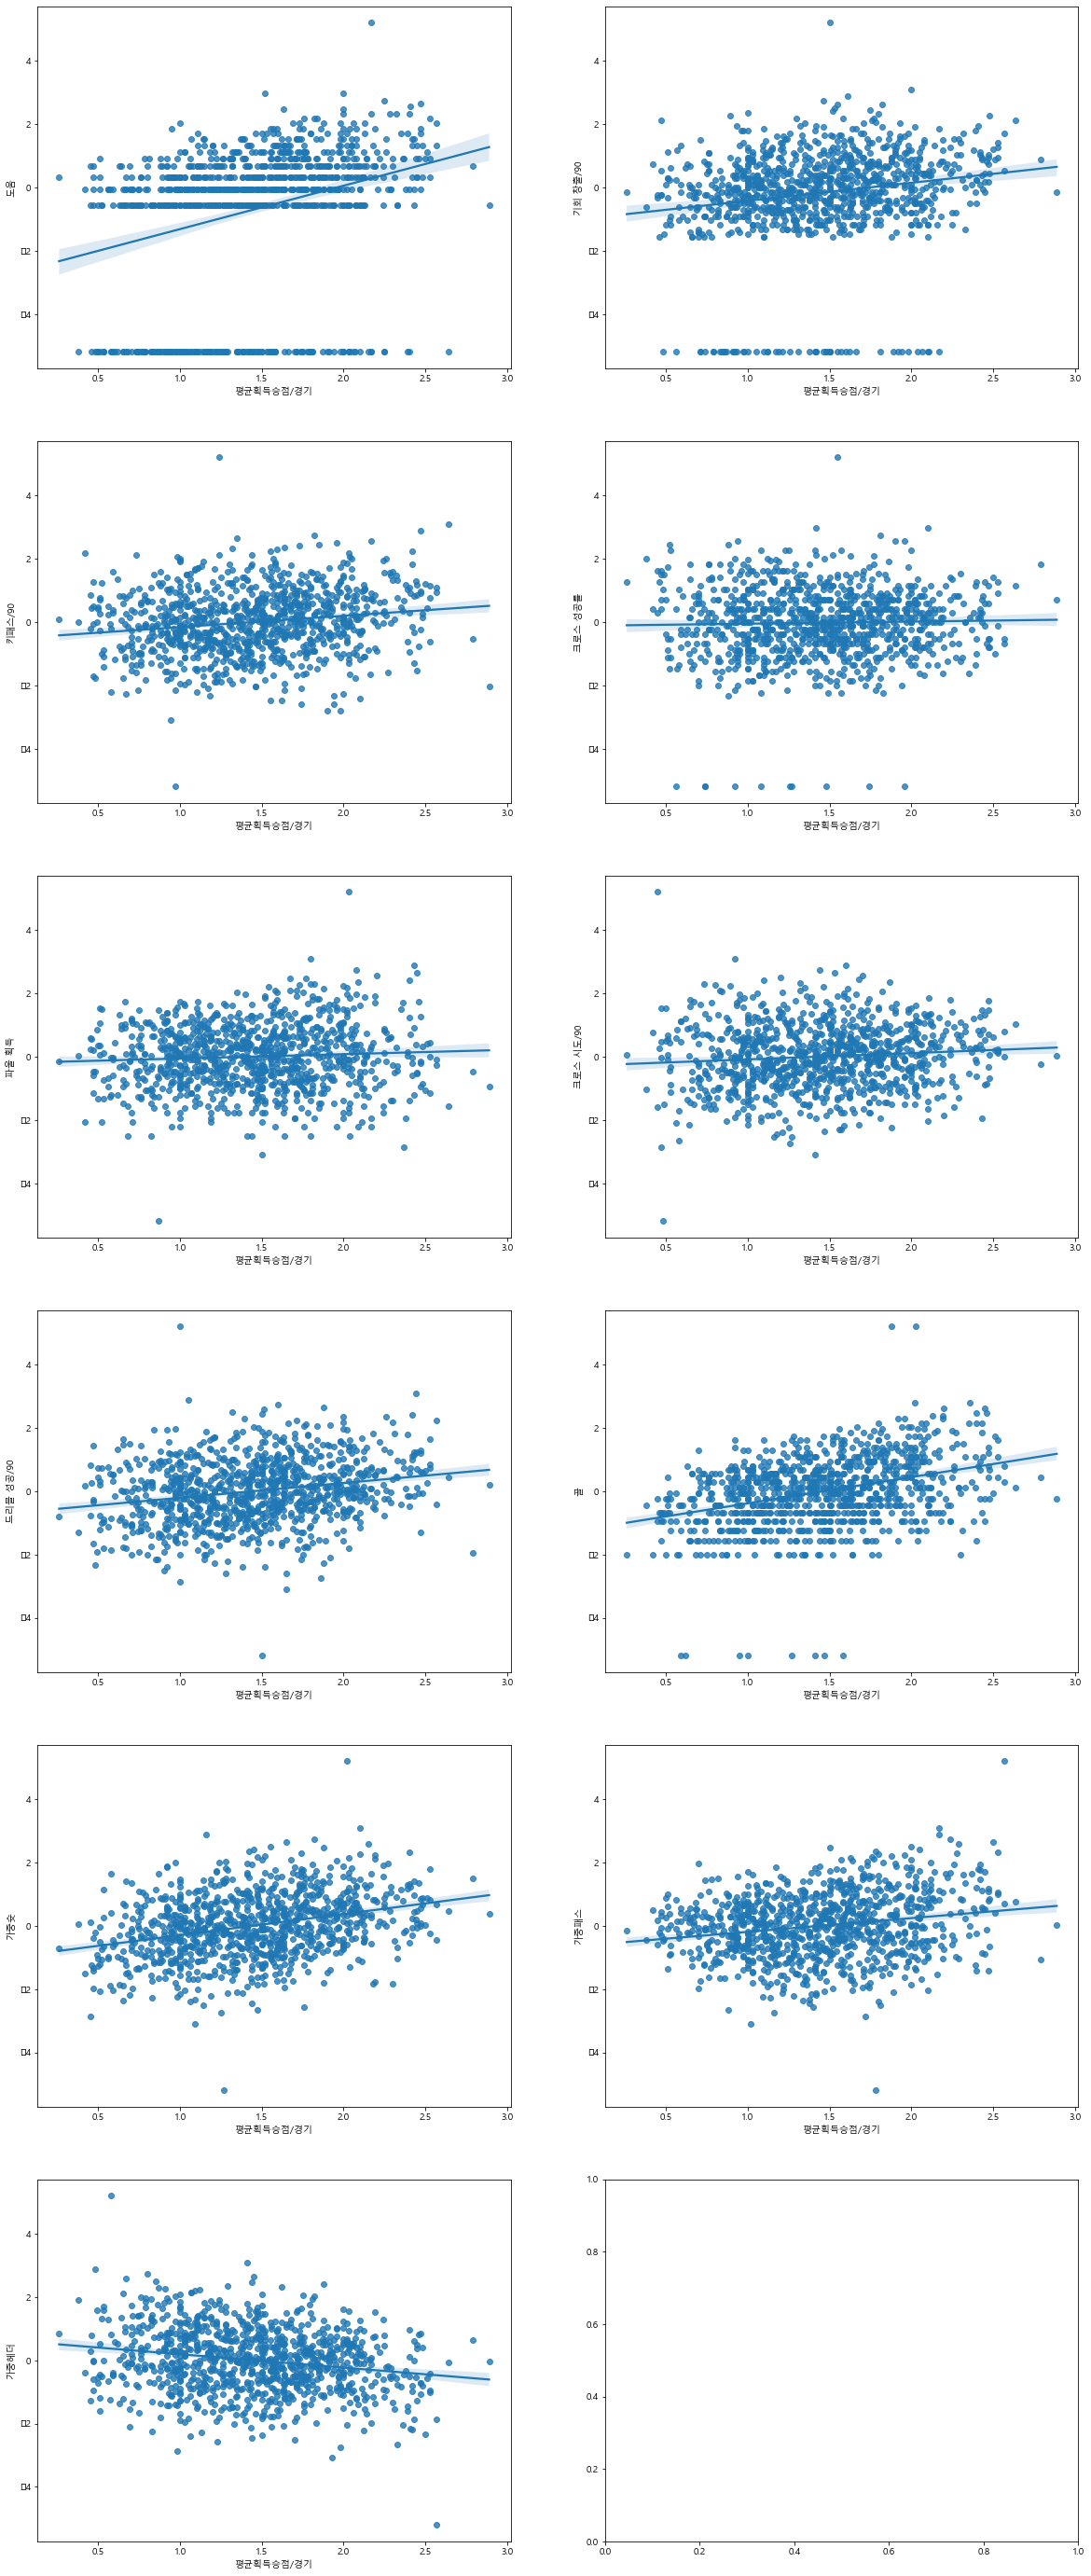

In [40]:
fig , axes = plt.subplots(6,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    sns.regplot(norm_forward_df.loc[:,target],norm_forward_df.loc[:,feature],ax=ax)
    
plt.show()

In [41]:
corr = [np.corrcoef(x ,y=forward_df.loc[:,target].T.values)[0][1] for x in forward_df.loc[:,features].T.values]

corr_dict = {}

for i,v in enumerate(corr):
    corr_dict[features[i]] = v

sorted(corr_dict.items(),key = lambda x : x[1],reverse=True)

[('골', 0.3899925372047754),
 ('도움', 0.3727750769369584),
 ('가중패스', 0.2546310274306389),
 ('기회 창출/90', 0.21355111596989557),
 ('드리블 성공/90', 0.21124806922396683),
 ('가중슛', 0.20588955822973576),
 ('키패스/90', 0.17434639122051926),
 ('파울 획득', 0.08483611536148467),
 ('크로스 시도/90', 0.06285626018412958),
 ('크로스 성공률', 0.01034149433563985),
 ('가중헤더', -0.20477001115195795)]

In [42]:
# 상관계수가 높은 변수

# 전진선택법을 위한 변수의 우선순위 순 


good_feature_order = ['골','도움','가중슛','가중패스','기회 창출/90',
                      '드리블 성공/90','키패스/90','파울 획득','크로스 시도/90',
                      '크로스 성공률','가중헤더']

forward_mae = []
forward_model = []

for i in range(1,len(good_feature_order)+1):
    
    print(good_feature_order[:i])
    
    fx_train,fx_test,fy_train,fy_test = train_test_split(norm_forward_df.loc[:,good_feature_order[:i]],norm_forward_df.loc[:,target],test_size=0.2)
    
    inputs_layer = Input(shape=(i,))
    hidden1 = Dense(64,activation='relu')(inputs_layer)
    hidden2 = Dense(32,activation='relu')(hidden1)
    hidden3 = Dense(16,activation='relu')(hidden2)
    output = Dense(1,activation='linear')(hidden3)
    model = Model(inputs=[inputs_layer],outputs=[output])
    model.compile(loss='mse',optimizer=Adam(lr=0.001))
    
    
    model.fit(fx_train,fy_train,batch_size=70,epochs=50,validation_data=(fx_test,fy_test))  
    predict_result=model.predict(fx_test)
    mae = mean_absolute_error(fy_test,predict_result)
    forward_mae.append(mae)
    forward_model.append(model)

['골']
Epoch 1/50
12/12 [==============================] - 1s 14ms/step - loss: 2.2249 - val_loss: 1.6360
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 1.7196 - val_loss: 1.1417
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 1.1577 - val_loss: 0.7157
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.7226 - val_loss: 0.4237
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.4444 - val_loss: 0.2596
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.3344 - val_loss: 0.2162
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.2725 - val_loss: 0.1861
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.2265 - val_loss: 0.1777
Epoch 9/50
12/12 [==============================] - 0s 4ms/step - loss: 0.2101 - val_loss: 0.1798
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.2033 - val_loss: 0.1809
Epoch 11/50


12/12 [==============================] - 0s 5ms/step - loss: 0.1457 - val_loss: 0.1586
Epoch 16/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1436 - val_loss: 0.1653
Epoch 17/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1420 - val_loss: 0.1550
Epoch 18/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1449 - val_loss: 0.1592
Epoch 19/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1407 - val_loss: 0.1619
Epoch 20/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1387 - val_loss: 0.1542
Epoch 21/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1368 - val_loss: 0.1603
Epoch 22/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1380 - val_loss: 0.1531
Epoch 23/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1369 - val_loss: 0.1547
Epoch 24/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1346 - val_loss: 0.1571
Epoch 25/50
12/12 [===

Epoch 29/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1124 - val_loss: 0.1469
Epoch 30/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1103 - val_loss: 0.1453
Epoch 31/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1104 - val_loss: 0.1446
Epoch 32/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1081 - val_loss: 0.1473
Epoch 33/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1084 - val_loss: 0.1449
Epoch 34/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1073 - val_loss: 0.1458
Epoch 35/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1063 - val_loss: 0.1472
Epoch 36/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1050 - val_loss: 0.1420
Epoch 37/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1060 - val_loss: 0.1457
Epoch 38/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1040 - val_loss: 0.1444
Epoch 39/5

Epoch 42/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0857 - val_loss: 0.1741
Epoch 43/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0838 - val_loss: 0.1717
Epoch 44/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0825 - val_loss: 0.1715
Epoch 45/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0832 - val_loss: 0.1741
Epoch 46/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0821 - val_loss: 0.1672
Epoch 47/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0801 - val_loss: 0.1725
Epoch 48/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0795 - val_loss: 0.1704
Epoch 49/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0785 - val_loss: 0.1727
Epoch 50/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0779 - val_loss: 0.1734
['골', '도움', '가중슛', '가중패스', '기회 창출/90', '드리블 성공/90', '키패스/90', '파울 획득', '크로스 시도/90', '크로스 성공률', '가중헤더']
Epoch 

In [43]:
forward_mae

[0.34395866509639855,
 0.32500413456348454,
 0.31634619317873564,
 0.3334932295842604,
 0.30862871112245505,
 0.30358750485410596,
 0.3207414626834368,
 0.31605743421448607,
 0.29496043948212053,
 0.32969742377599076,
 0.30454295969972706]

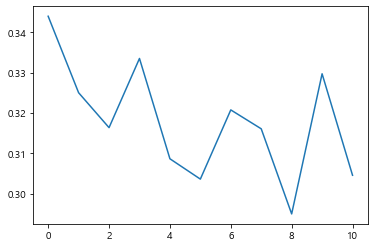

In [44]:
plt.plot(forward_mae)
plt.show()

In [45]:
good_features = good_feature_order[0:np.argmin(np.array(forward_mae))+1]
#good_features.append(good_feature_order[6])
good_features

['골',
 '도움',
 '가중슛',
 '가중패스',
 '기회 창출/90',
 '드리블 성공/90',
 '키패스/90',
 '파울 획득',
 '크로스 시도/90']

In [46]:
fx_train,fx_test,fy_train,fy_test = train_test_split(norm_forward_df.loc[:,good_features],norm_forward_df.loc[:,target],test_size=0.2)

In [47]:
xgb = XGBRegressor()
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}


xgb_grid = GridSearchCV(xgb,
                        params,
                        cv = 2,
                        n_jobs = 6,
                        refit=True,
                        verbose=True)

xgb_grid.fit(fx_train,fy_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 450 candidates, totalling 900 fits
0.4129245317850841
{'colsample_bytree': 0.7, 'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.9}


In [48]:
result = xgb_grid.predict(fx_test)
mean_absolute_error(fy_test,result)

0.2967757370736864

In [49]:
import lightgbm as lgb

params = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}

lgbm_grid = GridSearchCV(lgb.LGBMRegressor(random_state=0), params, scoring='r2',refit=True,cv=5)
lgbm_grid.fit(fx_train, fy_train)


result = lgbm_grid.predict(fx_test)
mean_absolute_error(fy_test,result)

0.28980214550696637

In [50]:
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor()

param_grid = { 
    "n_estimators"      : [10,20,30],
    "max_features"      : ["auto", "sqrt", "log2"],
    "min_samples_split" : [2,4,8],
    "bootstrap": [True, False],
}

rf_grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)
rf_grid.fit(fx_train, fy_train)

result = rf_grid.predict(fx_test)
mean_absolute_error(fy_test,result)

0.3035615233952355

In [51]:
from sklearn.ensemble import VotingRegressor

vr = VotingRegressor([('xgb',xgb_grid),('lgbm',lgbm_grid),('rf',rf_grid)])
vr.fit(fx_train, fy_train)
result = vr.predict(fx_test)
mean_absolute_error(fy_test,result)

Fitting 2 folds for each of 450 candidates, totalling 900 fits


0.28757660659851236

In [52]:
#model = load_model('./models/forward_nn.h5')

In [53]:
norm_forward_df['predict'] = vr.predict(norm_forward_df.loc[:,good_features])

# 모델 검정

In [54]:
residual = norm_forward_df['평균획득승점/경기'] - norm_forward_df['predict']

## 모형의 선형성 검정

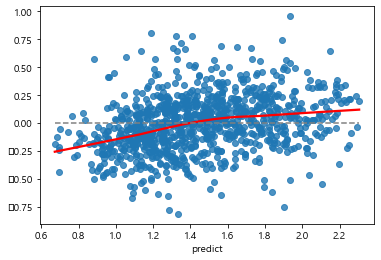

In [55]:
sns.regplot(norm_forward_df['predict'], residual, lowess=True, line_kws={'color': 'red'})
plt.plot([norm_forward_df['predict'].values.min(), norm_forward_df['predict'].values.max()], [0, 0], '--', color='grey')

## 정규성 검정

In [56]:
stats.shapiro(residual)

ShapiroResult(statistic=0.9963752627372742, pvalue=0.021480565890669823)

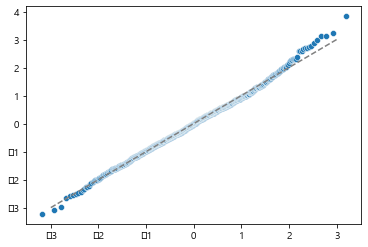

In [57]:
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

## 등분산성 검정

In [58]:
stats.levene(norm_forward_df['평균획득승점/경기'],norm_forward_df['predict'])

LeveneResult(statistic=114.51418909064358, pvalue=5.10159713827057e-26)

<AxesSubplot:>

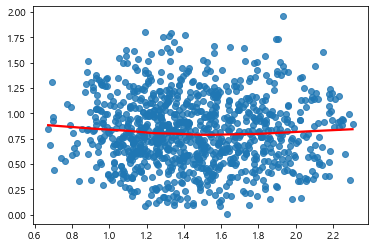

In [59]:
sns.regplot(norm_forward_df['predict'].values, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})